## Example 13 - Path selection by vessel limits

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Vaarwegvakken"
name_graph = "Vaarwegvakken.shp"

# Vessel database
location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda)):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

In [2]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)

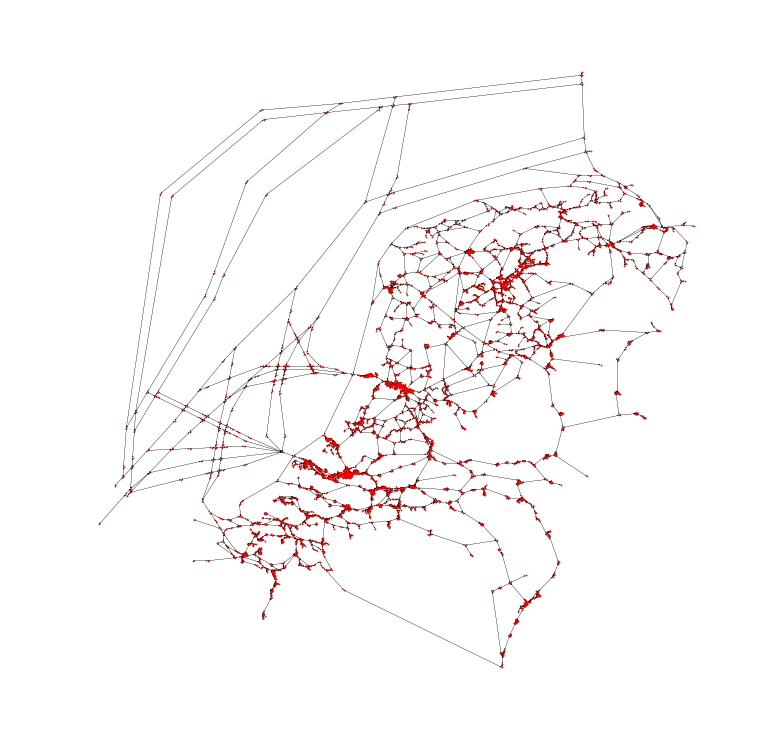

In [3]:
graph.create_graph_new_projection()
graph.plot()

We'll simulate vessels travelling from Utrecht to 's-Hertogenbosch. Given the properties of the graph the origin will be *Rijkshaven Utrecht* and the destination will be *Industriehavens 's-Hertogenbosch*. Resulting in the following nodes:

- Origin      (5.102283, 52.045830)
- Destination (5.289868, 51.698449)

The fasted route will be through the *Kanaal van Sint Andries*, but there is a lock in this canal. For this example we will not simulate the lock, but we will add restrictions to the canal so that not all vessesls can pass through. The edges we'll add restrictions to are between the following nodes. 

- Node 1 (5.368229, 51.791797)
- Node 2 (5.369157, 51.789972)

In [4]:
for i, edge in enumerate(graph.graph.edges(data = True)):
    if edge[0] == "(5.368229, 51.791797)" and edge[1] == "(5.369157, 51.789972)": 
        edge[2]["Height"] = 5.10
        edge[2]["Width"]  = 9.50
        edge[2]["Depth"]  = 3.50
    
    elif edge[1] == "(5.368229, 51.791797)" and edge[0] == "(5.369157, 51.789972)": 
        edge[2]["Height"] = 5.10
        edge[2]["Width"]  = 9.50
        edge[2]["Depth"]  = 3.50
        
    else:
        edge[2]["Height"] = 30
        edge[2]["Width"]  = 30
        edge[2]["Depth"]  = 30

### Create vessel database

In [5]:
vessel_db = pd.read_csv(location_vessel_database)
vessel_db.head()

,vessel_id,vessel_type,width,length,height_empty,height_full,draught_empty,draught_full,capacity,installed_power
0,12ad8a02-4aef-11e9-9940-b469212bff5b,CEMT - I,5.05,38.5,4.65,3.35,1.2,2.5,365,175
1,17746aee-4aef-11e9-8ebf-b469212bff5b,CEMT - II,6.60,55.0,5.80,4.60,1.4,2.6,615,250
2,1be5fb2e-4aef-11e9-9bfb-b469212bff5b,CEMT - III,8.20,85.0,6.30,5.10,1.5,2.7,1250,435
3,208a5aca-4aef-11e9-b7e9-b469212bff5b,CEMT - IV,9.50,105.0,6.70,5.30,1.6,3.0,2040,690
4,24f93100-4aef-11e9-8ff9-b469212bff5b,CEMT - Va,11.40,135.0,7.10,5.40,1.8,3.5,3735,1425


In [6]:
# Vessel type
Vessel = type('Vessel', 
              (core.Identifiable, core.Movable, core.HasContainer,
               core.VesselProperties, core.HasResource, core.Routeable), 
              {})

In [7]:
generator = model.VesselGenerator(Vessel, vessel_db, loaded = "Random")

### Run simulation

In [8]:
# Start simpy environment
simulation_start = datetime.datetime(2019, 1, 1)
sim = model.Simulation(simulation_start, graph.graph)

In [9]:
# Create a random path over the graph
sim.add_vessels(vessel_generator = generator, origin = "(5.102283, 52.045830)", destination = "(5.289868, 51.698449)")

In [10]:
%%time
# Run the simulation for 100 days
sim.run(duration = 100 * 24 * 60 * 60)

Wall time: 3min


### Check results

In [11]:
# The different routes that are sailed by various vessels
sim.environment.routes

,Origin,Destination,Width,Height,Depth,Route
0,"(5.102283, 52.045830)","(5.289868, 51.698449)",8.20,5.10,2.7,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
1,"(5.102283, 52.045830)","(5.289868, 51.698449)",9.50,5.30,3.0,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
2,"(5.102283, 52.045830)","(5.289868, 51.698449)",6.60,5.80,1.4,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
3,"(5.102283, 52.045830)","(5.289868, 51.698449)",6.60,4.60,2.6,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
4,"(5.102283, 52.045830)","(5.289868, 51.698449)",11.40,7.10,1.8,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
5,"(5.102283, 52.045830)","(5.289868, 51.698449)",5.05,3.35,2.5,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
6,"(5.102283, 52.045830)","(5.289868, 51.698449)",9.50,6.70,1.6,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
7,"(5.102283, 52.045830)","(5.289868, 51.698449)",5.05,4.65,1.2,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
8,"(5.102283, 52.045830)","(5.289868, 51.698449)",17.00,8.00,4.0,"[(5.102283, 52.045830), (5.101277, 52.043644),..."
9,"(5.102283, 52.045830)","(5.289868, 51.698449)",11.40,5.40,3.5,"[(5.102283, 52.045830), (5.101277, 52.043644),..."


In [12]:
# The unique routes that are sailed by various vessels
for i, route in enumerate(np.unique(sim.environment.routes["Route"].values)):
    print("Route", i + 1)
    print(route)
    print("")

Route 1
['(5.102283, 52.045830)', '(5.101277, 52.043644)', '(5.091862, 52.033049)', '(5.097429, 52.011960)', '(5.091495, 52.001898)', '(5.094756, 52.002476)', '(5.097104, 51.987961)', '(4.997334, 51.870905)', '(4.995742, 51.862002)', '(4.978824, 51.835302)', '(4.975283, 51.825915)', '(4.974508, 51.822931)', '(5.001849, 51.820973)', '(5.045007, 51.797969)', '(5.047170, 51.795611)', '(5.047887, 51.794822)', '(5.054099, 51.789834)', '(5.142991, 51.755042)', '(5.142257, 51.754277)', '(5.126553, 51.737363)', '(5.143332, 51.740104)', '(5.175243, 51.742989)', '(5.249969, 51.733617)', '(5.275505, 51.710920)', '(5.281893, 51.707008)', '(5.289868, 51.698449)']

Route 2
['(5.102283, 52.045830)', '(5.101277, 52.043644)', '(5.106011, 52.048689)', '(5.111625, 52.039067)', '(5.339617, 51.960947)', '(5.352739, 51.955821)', '(5.361965, 51.952093)', '(5.440386, 51.916553)', '(5.461108, 51.888592)', '(5.444947, 51.884014)', '(5.349217, 51.804087)', '(5.358267, 51.797610)', '(5.368229, 51.791797)', '(5.36